In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import pydotplus
from IPython.display import Image
from pylab import rcParams
from sklearn import metrics, preprocessing, tree
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from io import StringIO
import warnings
from sklearn import tree

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 6, 6
warnings.filterwarnings("ignore")

**Decision Tree Classifiers** are models very interesting if what we are interested in is the **interoperability**. **Interoperability** refers to the basic ability of different computerized products or systems to readily connect and exchange information with one another, in either implementation or access, without restriction. As the name suggests, a **Decision Tree** splits data taking decisions according to the answers to certain questions. 

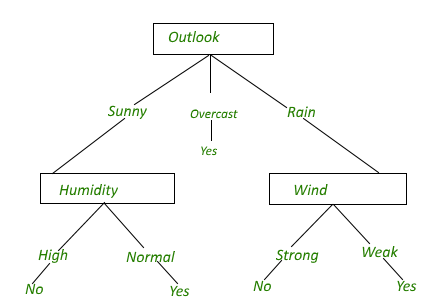

The concept of Decision Tree which is based on categorical variables is the same as the one applied to numerical features, such as in Iris Dataset. For instance, we might simply define a separation value for the feature "**sepal width** and take the binary question: “**sepal width ≥ 2.8 cm?**”. By exploiting the decisional algorithm, we start from the tree root and we divide data on the base of the feature yielding the maximum **Information Gain** (IG). We then exploit an iterative process and we are able to repeat this procedure of each child node subdivision, up to the pure leaves. This means that sample belonging to the same node belong to the same class. In the real life, this can lead to a very deep and wide Decision Tree with a lot of nodes. This might bring towards the **Overfitting** problem, therefore, what we tipically do is pruning the Decision Tree setting a limit to its depth. 

In order to split nodes based on the more informative features, we define an **objective function** which we are willing to optimize with the **Training Algorithm** for Decision Trees. So, the objective function aims to maximize the the Information Gain after each subdivision: 

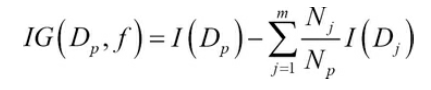

Where, **f** is our feature which we base our subdivision on, **Dp** and **Dj** are the dataset of the parend *p* and the child *j*, **I** is our **Impurity** measure, **Np** is the total amount of samples in the parent Node *p-th*, whereas **Nj** is the number of samples in the *j-th* child Node. As we can see, the information gain is simply the gap between the **Impurity** of the parent node and the sum of the impurities of the children nodes: the Less the impurity of children nodes, the More the information gain. However, for simplicity, and for reducing the combinatorial search space, the most of Machine Learning libraries, implements Binary Decision Trees such as Scikit-Learn. This means that every **Parent Node** has two **Children Nodes**: 

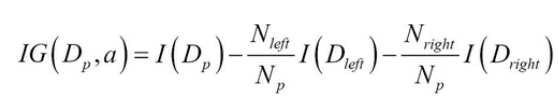

Now, we have 3 Impurity Measures that we commonly adopt as subdivision criterion within the field of Decision Trees: **Gini Impurity (Ig)**, **Entropy (Ih)**, and **Classification Error (Ie)**. 

Let's start from **Entropy** for all the non-empty classes: 

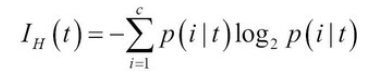

Where **p(i|t)** is the proportion of samples belonging to the class *c* for a determined node *t*. Therefore, the entropy is 0 if all the samples of a Node belong to the same class while it is maximum if we have an Uniform distribution of classes. Hence, the **Entropy** criterion tends to maximize the reciprocal information within an Decision Tree. 

On the other side, the **Gini Impurity** can be considered as a criterion to minimize the probability of an incorrect classification: 

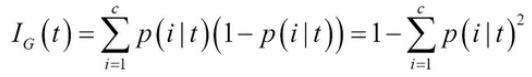

Just like the **Entropy**, **Gini Impurity** is maximum whenever are perfectly mixed such as in a binary class **(c=2)**:

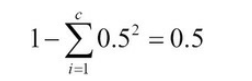

In the practice, both **Gini Impurity** and **Entropy** generally provide similar risults. 

Another measure for the **Impurity** is the **Classification Error**: 

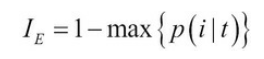

This is a useful criterion for the **Pruning**, but it is not recomended to train a Decision Tree since it is less sensitive to changes of probabilities that nodes belong to determined classes. 


For more intuitive comparisons, of the 3 different impurity criteria, we trace them of the probability range [0, 1] for the class 1. We can note that **Gini Impurity** is an intermediate measure between the **Entropy** and **Classification Error**. 

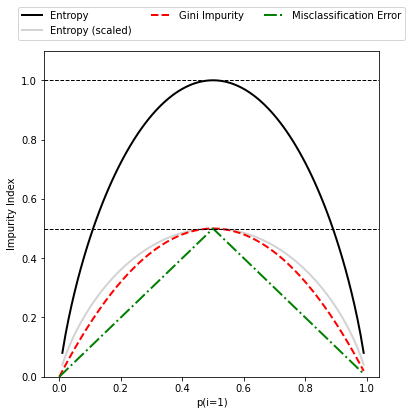

In [3]:
def gini(p): 
  return (p)*(1 - (p)) + (1 - p)*(1 - (1-p)) 

def entropy(p): 
  return - p*np.log2(p) - (1 - p)*np.log2((1 - p)) 

def error(p): 
  return 1 - np.max([p, 1 - p]) 

x = np.arange(0.0, 1.0, 0.01) 
ent = [entropy(p) if p != 0 else None for p in x] 
sc_ent = [e*0.5 if e else None for e in ent] 
err = [error(i) for i in x] 
fig = plt.figure()

ax = plt.subplot(111) 
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'], ['-', '-', '--', '-.'], ['black', 'lightgray', 'red', 'green', 'cyan']): 
  line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c) 

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=False) 
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--') 
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--') 
plt.ylim([0, 1.1]) 
plt.xlabel('p(i=1)') 
plt.ylabel('Impurity Index') 
plt.show()

#**Functions Definitions**

In [4]:
def plot_decision_tree(clf,feature_name,target_name):
    dot_data = StringIO()  
    tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_name,  
                         class_names=target_name,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    plt.savefig("./dt.png")
    return Image(graph.create_png())

#**Load datasets for classification**

In [5]:
# read the train and test dataset
class_train_data = pd.read_csv('https://raw.githubusercontent.com/vamsivarma/datasets/master/machine_learning/logistic_regression/train.csv')
class_test_data = pd.read_csv('https://raw.githubusercontent.com/vamsivarma/datasets/master/machine_learning/logistic_regression/test.csv')

# seperate the independent and target variable on training data
class_train_x = class_train_data.drop(columns=['Survived'],axis=1)
class_train_y = class_train_data['Survived']

# seperate the independent and target variable on testing data
class_test_x = class_test_data.drop(columns=['Survived'],axis=1)
class_test_y = class_test_data['Survived']

In [6]:
from sklearn.tree import DecisionTreeClassifier as dt
clf = dt()

In [7]:
clf

DecisionTreeClassifier()

In [8]:
# Fit the model
clf.fit(class_train_x, class_train_y)

# Make predictions
class_train_pred = clf.predict(class_train_x)
class_test_pred = clf.predict(class_test_x)

In [9]:
train_cols = class_train_x.columns
train_cols

Index(['Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4',
       'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3',
       'Parch_4', 'Parch_5', 'Parch_6', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [10]:
target_cols = class_train_y.name

In [11]:
target_cols


'Survived'

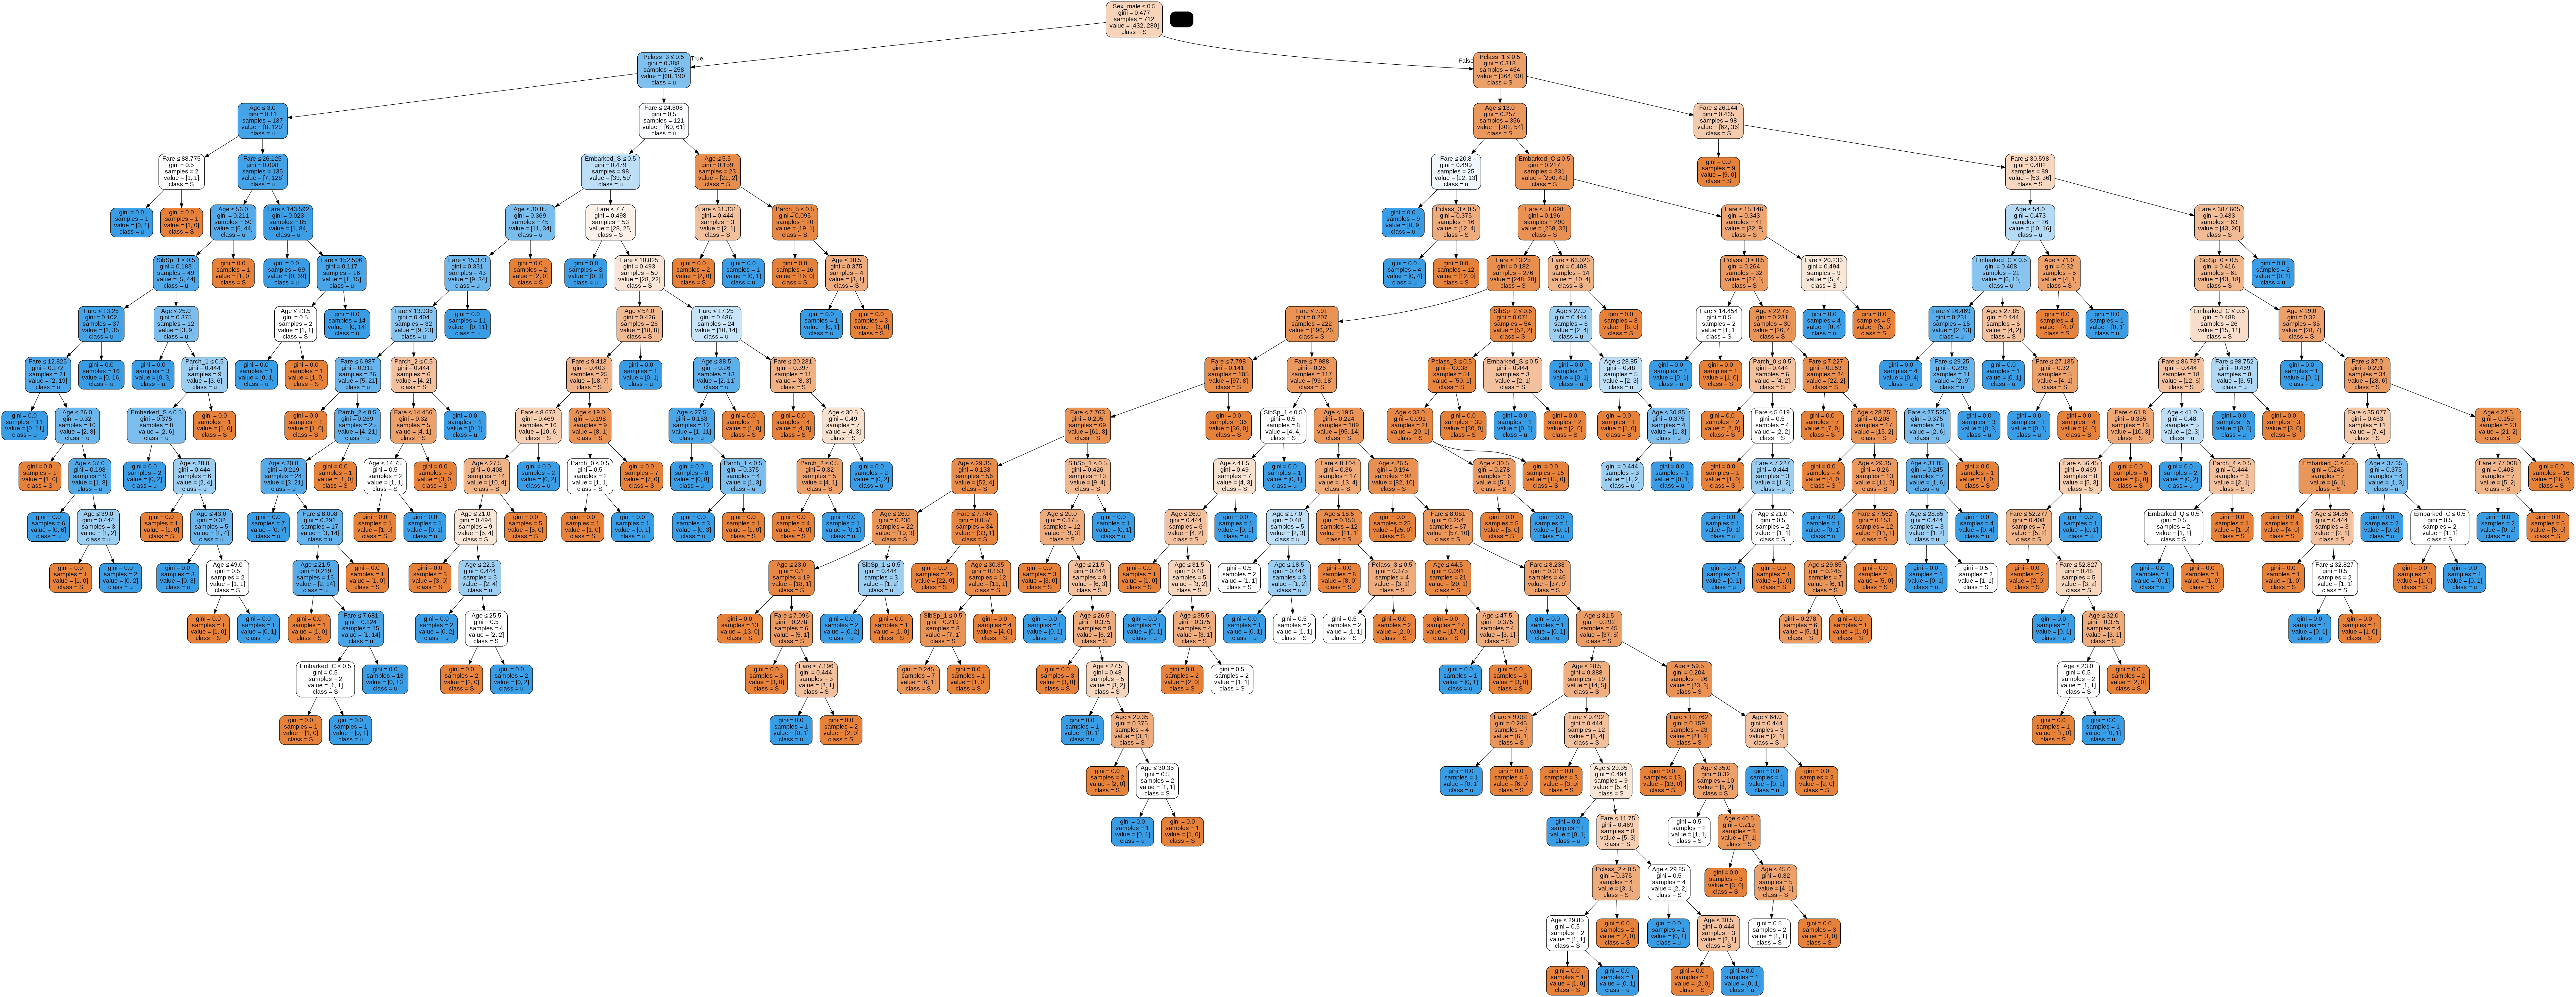

<Figure size 432x432 with 0 Axes>

In [12]:
plot_decision_tree(clf, train_cols, target_cols)

In [13]:
print('The Training F1 Score is', f1_score(class_train_pred, class_train_y))
print('The Testing F1 Score is', f1_score(class_test_pred, class_test_y))

The Training F1 Score is 0.9818840579710145
The Testing F1 Score is 0.6917293233082707


In [14]:
parameters = {
              'max_depth':[1,2,3,4,5], 
              'min_samples_leaf':[1,2,3,4,5], 
              'min_samples_split':[2,3,4,5], 
              'criterion' : ['gini','entropy']
             }
scorer = make_scorer(f1_score)

#**Scikit-Learn Model Selection**

#**Grid Search**

Exhaustive search over specified parameter values for an estimator.

**GridSearchCV** implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

In [15]:
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

In [16]:
grid_fit = grid_obj.fit(class_train_x, class_train_y)

In [17]:
best_clf = grid_fit.best_estimator_

In [18]:
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)

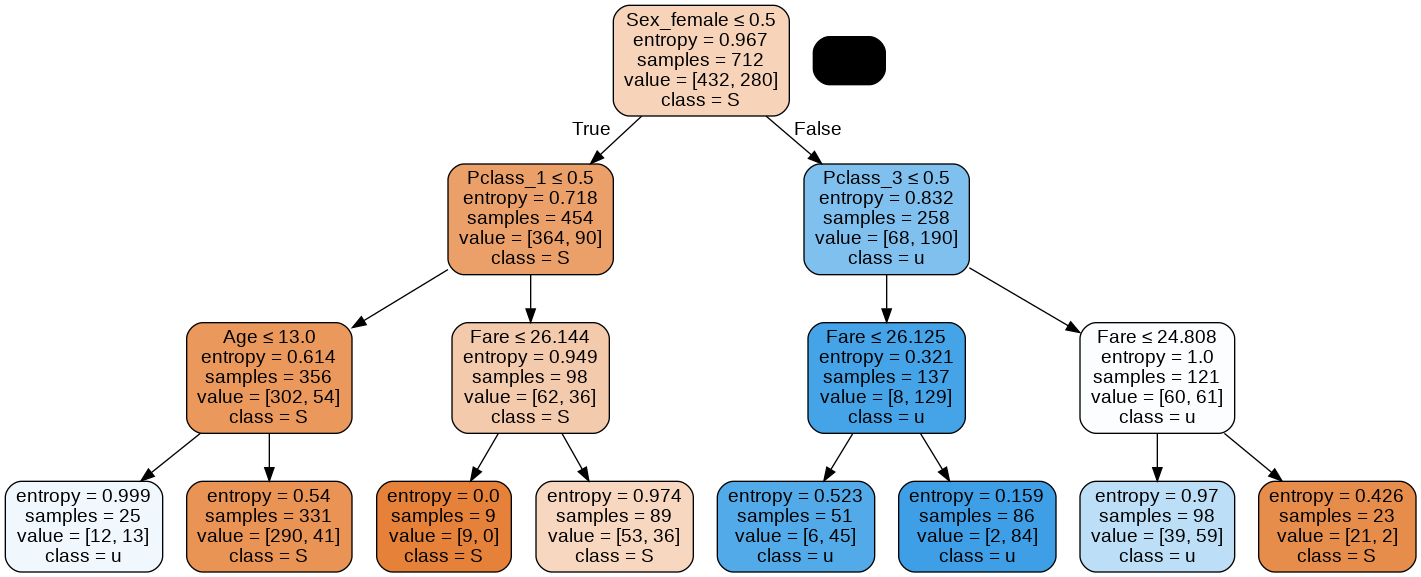

<Figure size 432x432 with 0 Axes>

In [19]:
plot_decision_tree(best_clf, train_cols, target_cols)

#**Cross_val_score**

Evaluate a score by cross-validation.

In [20]:
scores = cross_val_score(best_clf, class_train_x, class_train_y, cv=5, scoring='f1_macro')
scores.mean()

0.7977421935798411

In [21]:
best_clf.fit(class_train_x, class_train_y)

# Make predictions using the new model.
best_train_predictions = best_clf.predict(class_train_x)
best_test_predictions = best_clf.predict(class_test_x)

# Calculate the f1_score of the new model.
print('The training F1 Score is', f1_score(best_train_predictions, class_train_y))
print('The testing F1 Score is', f1_score(best_test_predictions, class_test_y))

The training F1 Score is 0.7444444444444445
The testing F1 Score is 0.7559055118110236


#**Random Search**

**Randomized** search on hyper parameters.

**RandomizedSearchCV** implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

In contrast to **GridSearchCV**, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

If all parameters are presented as a list, sampling without replacement is performed. If at least one parameter is given as a distribution, sampling with replacement is used. It is highly recommended to use continuous distributions for continuous parameters.

In [22]:
random_obj = RandomizedSearchCV(clf, parameters, scoring=scorer)

In [23]:
random_fit = random_obj.fit(class_train_x, class_train_y)

In [24]:
random_best_clf = random_fit.best_estimator_

In [25]:
random_best_clf

DecisionTreeClassifier(max_depth=3, min_samples_split=5)

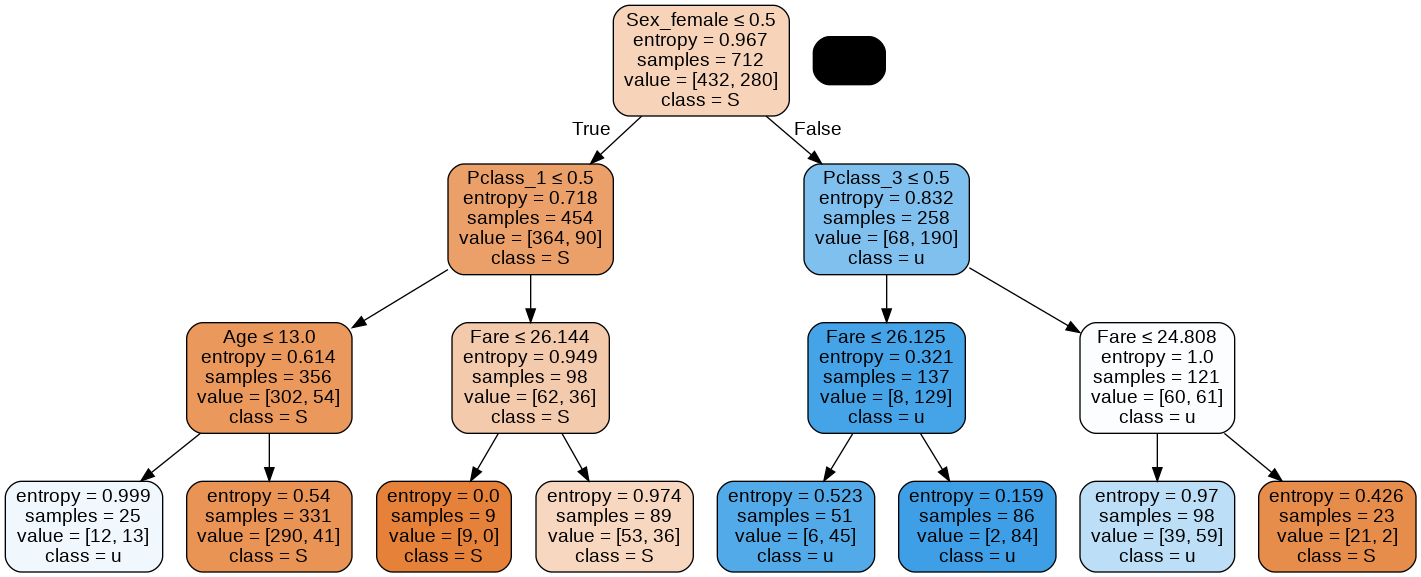

<Figure size 432x432 with 0 Axes>

In [26]:
plot_decision_tree(best_clf, train_cols, target_cols)

In [27]:
scores = cross_val_score(random_best_clf, class_train_x, class_train_y, cv=5, scoring='f1_macro')
scores.mean()

0.7884930349797098

In [28]:
random_best_clf.fit(class_train_x, class_train_y)

# Make predictions using the new model.
random_best_train_predictions = random_best_clf.predict(class_train_x)
random_best_test_predictions = random_best_clf.predict(class_test_x)

# Calculate the f1_score of the new model.
print('The training F1 Score is', f1_score(random_best_train_predictions, class_train_y))
print('The testing F1 Score is', f1_score(random_best_test_predictions, class_test_y))

The training F1 Score is 0.7434944237918215
The testing F1 Score is 0.7460317460317459


#References:

Kingsford, C., & Salzberg, S. L. (2008). What are decision trees?. Nature biotechnology, 26(9), 1011-1013.

Liashchynskyi, P., & Liashchynskyi, P. (2019). Grid search, random search, genetic algorithm: A big comparison for NAS. arXiv preprint arXiv:1912.06059.

#**Homeworks**

1) Make Decision Tree Grid and Random Serch on Iris Dataset

2) Try to make Grid Search and Random Search on some other Machine Learning Classfiers such as: Naive Bayes, Random Forest and Support Vector Machines